# Import Packages

In [1]:

#!pip3 install mlxtend
#!!pip3 install xgboost

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from sklearn.impute import SimpleImputer


from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance


from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Datasets

In [2]:
train = pd.read_csv(r"C:\Users\Jiayi\OneDrive - ucsc.edu\python\project\housing_kaggle\train.csv")
test = pd.read_csv(r"C:\Users\Jiayi\OneDrive - ucsc.edu\python\project\housing_kaggle\test.csv")


## Exploratory Data Analysis

In [3]:
def eda(df, pred=None):
    obs=df.shape[0]
    types=df.dtypes
    counts=df.apply(lambda x: x.count())
    uniques=df.apply(lambda x: [x.unique()])
    nulls=df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)
    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n', str.types.value_counts())
    print('___________________________')
    return str

In [4]:
details = eda(train, 'SalePrice')
pd.set_option('display.max_rows', train.shape[0]+1)
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1460, 72)
___________________________
Data types:
 int64      35
object     34
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr SalePrice
SalePrice,int64,1460,663,0,0.000,"[[208500, 181500, 223500, 140000, 250000, 1430...",1.883,6.536,1.000
OverallQual,int64,1460,10,0,0.000,"[[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]]",0.217,0.096,0.791
GrLivArea,int64,1460,861,0,0.000,"[[1710, 1262, 1786, 1717, 2198, 1362, 1694, 20...",1.367,4.895,0.709
GarageCars,int64,1460,5,0,0.000,"[[2, 3, 1, 0, 4]]",-0.343,0.221,0.640
GarageArea,int64,1460,441,0,0.000,"[[548, 460, 608, 642, 836, 480, 636, 484, 468,...",0.180,0.917,0.623
TotalBsmtSF,int64,1460,721,0,0.000,"[[856, 1262, 920, 756, 1145, 796, 1686, 1107, ...",1.524,13.250,0.614
1stFlrSF,int64,1460,753,0,0.000,"[[856, 1262, 920, 961, 1145, 796, 1694, 1107, ...",1.377,5.746,0.606
FullBath,int64,1460,4,0,0.000,"[[2, 1, 3, 0]]",0.037,-0.857,0.561
TotRmsAbvGrd,int64,1460,12,0,0.000,"[[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]]",0.676,0.881,0.534
YearBuilt,int64,1460,112,0,0.000,"[[2003, 1976, 2001, 1915, 2000, 1993, 2004, 19...",-0.613,-0.440,0.523


## Fix Missing Values

In [5]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
print("There are {0} rows and {1} columns in the combined data set".format(all_data.shape[0], all_data.shape[1]))
details = eda(all_data)


There are 2919 rows and 72 columns in the combined data set
Data shape: (2919, 72)
___________________________
Data types:
 object     34
int64      26
float64    12
Name: types, dtype: int64
___________________________


In [6]:
print('\nBelow the table with all columns with nulls oredered by missin ration:')
display(details.loc[(details.nulls>0), 'types':'uniques'].sort_values(by= 'missing ration', ascending=False))


Below the table with all columns with nulls oredered by missin ration:


,types,counts,distincts,nulls,missing ration,uniques
PoolQC,object,10,4,2909,99.657,"[[nan, Ex, Fa, Gd]]"
SalePrice,float64,1460,664,1459,49.983,"[[208500.0, 181500.0, 223500.0, 140000.0, 2500..."
FireplaceQu,object,1499,6,1420,48.647,"[[nan, TA, Gd, Fa, Ex, Po]]"
LotFrontage,float64,2433,129,486,16.650,"[[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, na..."
GarageCond,object,2760,6,159,5.447,"[[TA, Fa, nan, Gd, Po, Ex]]"
GarageQual,object,2760,6,159,5.447,"[[TA, Fa, Gd, nan, Ex, Po]]"
GarageFinish,object,2760,4,159,5.447,"[[RFn, Unf, Fin, nan]]"
GarageYrBlt,float64,2760,104,159,5.447,"[[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993..."
GarageType,object,2762,7,157,5.379,"[[Attchd, Detchd, BuiltIn, CarPort, nan, Basme..."
BsmtCond,object,2837,5,82,2.809,"[[TA, Gd, nan, Fa, Po]]"


In [7]:
# Fix Garage related features
feat = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']
print(all_data[feat].isnull().sum())
print("GarageArea equal a 0: ", (all_data["GarageArea"]==0).sum())
print("GarageCars equal a 0: ", (all_data["GarageCars"]==0).sum())


GarageYrBlt     159
GarageType      157
GarageFinish    159
GarageQual      159
GarageCond      159
GarageArea        1
GarageCars        1
dtype: int64
GarageArea equal a 0:  157
GarageCars equal a 0:  157


In [8]:
all_data["GarageType"] = all_data["GarageType"].fillna('NA')
# For numerical Garage features: Group by GarageType and fill missing value with median where GarageType=='Detchd' and 0 for the others
cmedian = all_data[all_data["GarageType"]=='Detchd'].GarageArea.median()

all_data.loc[all_data["GarageType"]=='Detchd', 'GarageArea'] = all_data.loc[all_data.GarageType=='Detchd',                                                                          'GarageArea'].fillna(cmedian)
all_data["GarageArea"] = all_data["GarageArea"].fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageCars.median()

all_data.loc[all_data.GarageType=='Detchd', 'GarageCars'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCars'].fillna(cmedian)
all_data.GarageCars = all_data.GarageCars.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageYrBlt.median()

all_data.loc[all_data.GarageType=='Detchd', 'GarageYrBlt'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                          'GarageYrBlt'].fillna(cmedian)
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(0)


# For categorical Garage features: Group by GarageType and fill missing value with mode where GarageType=='Detchd' and 'NA' for the others
cmode = all_data[all_data.GarageType=='Detchd'].GarageFinish.mode()[0]

all_data.loc[all_data.GarageType=='Detchd', 'GarageFinish'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                           'GarageFinish'].fillna(cmode)
all_data.GarageFinish = all_data.GarageFinish.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageQual.mode()[0]

all_data.loc[all_data.GarageType=='Detchd', 'GarageQual'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageQual'].fillna(cmode)
all_data.GarageQual = all_data.GarageQual.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageCond.mode()[0]

all_data.loc[all_data.GarageType=='Detchd', 'GarageCond'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCond'].fillna(cmode)
all_data.GarageCond = all_data.GarageCond.fillna('NA')


# Check if everything is fixed
print(all_data[feat].isnull().sum())

GarageYrBlt     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
GarageArea      0
GarageCars      0
dtype: int64


In [9]:
# Fix masonry veneer types

#deal with null
feat = ['MasVnrArea', 'MasVnrType']
c = all_data[~all_data.MasVnrArea.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')
print("Has MasVnrType but not has MasVnrArea:",all_data[~all_data.MasVnrType.isnull()].MasVnrArea.isnull().sum())
print("Has MasVnrArea but not has MasVnrType:",c[c.MasVnrType.isnull()].MasVnrArea.count())


print("Has MasVnrType but MasVnrArea is equal a Zero:",c[c.MasVnrArea==0].MasVnrType.count())
print("MasVnrArea equal a 0: ", (all_data.MasVnrArea==0).sum(), '\n')

#deal with None
print("Has MasVnrTypeType but Area == 0:")
print(c[c.MasVnrArea==0].MasVnrType.value_counts(), '\n')

print("Type None with Area > 0 ?")
print(all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType','MasVnrArea']])

print('\n What is the most comumn MasVnrType after None?')
print(all_data.MasVnrType.value_counts())

Masonry veneer Nulls:
MasVnrArea    23
MasVnrType    24
dtype: int64 

Has MasVnrType but not has MasVnrArea: 0
Has MasVnrArea but not has MasVnrType: 1
Has MasVnrType but MasVnrArea is equal a Zero: 1738
MasVnrArea equal a 0:  1738 

Has MasVnrTypeType but Area == 0:
None       1735
BrkFace       2
Stone         1
Name: MasVnrType, dtype: int64 

Type None with Area > 0 ?
     MasVnrType  MasVnrArea
624        None     288.000
773        None       1.000
1230       None       1.000
1300       None     344.000
1334       None     312.000
1669       None     285.000
2452       None       1.000

 What is the most comumn MasVnrType after None?
None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64


In [10]:
# All None and Null Types with Area greater than 0 update to the most common type: BrkFace
all_data.loc[(all_data["MasVnrType"]=="None") & (all_data["MasVnrArea"]>0),["MasVnrType"]]="BrkFace"
all_data.loc[(all_data["MasVnrType"].isnull()) & (all_data["MasVnrArea"]>0),["MasVnrType"]]="BrkFace"

# All Types different from None with Area equal to 0 update to median Area of no None types with Areas
all_data.loc[(all_data.MasVnrType!='None') & 
             (all_data.MasVnrArea==0), ['MasVnrArea']] = all_data.loc[(all_data.MasVnrType!='None') & 
                                                                      (all_data.MasVnrArea>0), ['MasVnrArea']].median()[0]
# Filling 0 and None for records wheres both are nulls
all_data.MasVnrArea = all_data.MasVnrArea.fillna(0)
all_data.MasVnrType = all_data.MasVnrType.fillna('None')


# Check if everything is fixed
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')

Masonry veneer Nulls:
MasVnrArea    0
MasVnrType    0
dtype: int64 



In [11]:
# Fix Basement related Features
feat = ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 
        'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
print(all_data[feat].isnull().sum())
print("BsmtFinSF1 equal a 0: ", (all_data.BsmtFinSF1==0).sum())
print("BsmtFinSF2 equal a 0: ", (all_data.BsmtFinSF2==0).sum())
print("BsmtUnfSF equal a 0: ", (all_data.BsmtUnfSF==0).sum())
print("TotalBsmtSF equal a 0: ", (all_data.TotalBsmtSF==0).sum())
print("BsmtFullBath equal a 0: ", (all_data.BsmtFullBath==0).sum())
print("BsmtHalfBath equal a 0: ", (all_data.BsmtHalfBath==0).sum())

BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
dtype: int64
BsmtFinSF1 equal a 0:  929
BsmtFinSF2 equal a 0:  2571
BsmtUnfSF equal a 0:  241
TotalBsmtSF equal a 0:  78
BsmtFullBath equal a 0:  1705
BsmtHalfBath equal a 0:  2742


In [12]:
# Besides No Basement , Av is the most comumn BsmtExposure. 
display(all_data.BsmtExposure.value_counts())

# Update nulls Exposure to Av wheres TotalBsmntSF>0
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & 
             (all_data.BsmtExposure.isnull()) & 
             (all_data.TotalBsmtSF>0), 'BsmtExposure'] = 'Av'


# TA is the most comumn BsmtQual. 
display(all_data.BsmtQual.value_counts())

# We use TA for all cases wheres has same evidenci that the house has Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & 
             (all_data.BsmtQual.isnull()) & 
             (all_data.TotalBsmtSF>0), 'BsmtQual'] = 'TA'

# TA is the most comumn BsmtCond. 
display(all_data.BsmtCond.value_counts())

# We use TA for all cases wheres has same evidenci that the house has Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & (all_data.BsmtCond.isnull()) & (all_data.TotalBsmtSF>0), 'BsmtCond'] = 'TA'



# Unf is the most comumn BsmtFinType2. 
display(all_data.BsmtFinType2.value_counts())

# We use Unf for all cases wheres BsmtFinType2 is null but BsmtFinSF2>0
all_data.loc[(all_data.BsmtFinSF2>0) & (all_data.BsmtFinType2.isnull()) , 'BsmtFinType2'] = 'Unf'


# See below that we have one case where BsmtFinType2 is BLQ and the Area is Zero, but its area was inputed at Unfinesh
#display(all_data[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull())][feat])

# Correct BsmtFinSF2 and BsmtUnfSF:
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtFinSF2'] = 354.0
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtUnfSF'] = 0.0

     
# All these cases are clear don´t have basement. 
print("Rest cases where Cond is Null", (all_data[all_data.BsmtCond.isnull()]).shape[0], '\n')
print('Others categories basement features are Null when Cond is Null:\n',
      (all_data[all_data.BsmtCond.isnull()][['BsmtQual', 'BsmtCond', 'BsmtExposure',
                                             'BsmtFinType1' , 'BsmtFinType2']]).isnull().sum())
print('\nOthers numerics basement features are Null or Zero when Cond is Null:\n',
      all_data[all_data.BsmtCond.isnull()][['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' ,'TotalBsmtSF',
                                            'BsmtFullBath', 'BsmtHalfBath']].sum())

# So, we update these Zero or NA according to their dictionary:
nulls_cols = {'BsmtExposure': 'NA', 'BsmtFinType2': 'NA', 'BsmtQual': 'NA', 'BsmtCond': 'NA', 'BsmtFinType1': 'NA',
              'BsmtFinSF1': 0, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0 ,'TotalBsmtSF': 0, 'BsmtFullBath': 0, 'BsmtHalfBath': 0}

all_data = all_data.fillna(value=nulls_cols)


# Check if everything is fixed
print('\nFinal Check if all nulls basement features are treated:', all_data[feat].isnull().sum().sum())    


No    1904
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64

Unf    2493
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

Rest cases where Cond is Null 79 

Others categories basement features are Null when Cond is Null:
 BsmtQual        79
BsmtCond        79
BsmtExposure    79
BsmtFinType1    79
BsmtFinType2    79
dtype: int64

Others numerics basement features are Null or Zero when Cond is Null:
 BsmtFinSF1     0.000
BsmtFinSF2     0.000
BsmtUnfSF      0.000
TotalBsmtSF    0.000
BsmtFullBath   0.000
BsmtHalfBath   0.000
dtype: float64

Final Check if all nulls basement features are treated: 0


In [13]:
#fix lotfontage
NegMean = all_data.groupby('Neighborhood').LotFrontage.mean()

all_data["LotFrontage"] = all_data[['Neighborhood', 'LotFrontage']].\
                           apply(lambda x: NegMean[x.Neighborhood] if np.isnan(x.LotFrontage) else x.LotFrontage, axis=1)

#print(all_data["LotFrontage"])



In [14]:
#fix pool quality 
# fill null of PoolQC that has Pool Area with based on the Overall Quality of the houses divided by 2.
PoolQC = {0: 'NA', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['PoolQC']] =\
        ((all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['OverallQual']]/2).round()).\
        apply(lambda x: x.map(PoolQC))
all_data.PoolQC = all_data.PoolQC.fillna('NA')
#display (all_data[["PoolQC"]].head(3000))

In [15]:
# fix fireplace Quality 
all_data.loc[(all_data.Fireplaces==0) & (all_data.FireplaceQu.isnull()), ['FireplaceQu']] = 'NA'
#display (all_data[["Fireplaces"]].head(3000))

In [16]:
# fix Kitchen Quality 
all_data.loc[(all_data.KitchenAbvGr>0) & (all_data.KitchenQual.isnull()), 
             ['KitchenQual']] = all_data.KitchenQual.mode()[0]
#display (all_data[["KitchenQual"]].isnull().any())

In [17]:
# fix Garage Year Build typo
#display(all_data.loc[all_data.GarageYrBlt==2207, ['GarageYrBlt', 'YearBuilt']])
all_data.loc[all_data.GarageYrBlt==2207.0, 'GarageYrBlt'] = 2007.0


In [18]:
imp=SimpleImputer(missing_values=np.nan, strategy='constant')
all_data2 = pd.DataFrame(imp.fit_transform(all_data))
# Final check if we have some NA
print("Data nulls:", all_data2.isnull().sum().sum())

Data nulls: 0


## Map Ordinal Features

In [19]:
def map_ordinals(data):
    OrdinalFeatures = {}
    OrdinalFeatures['Ex'] = 5 #'Excellent'
    OrdinalFeatures['Gd'] = 4 #'Good'
    OrdinalFeatures['TA'] = 3 #'Average/Typical'
    OrdinalFeatures['Fa'] = 2 #'Fair'
    OrdinalFeatures['Po'] = 1 #'Poor'
    OrdinalFeatures['NA'] = 0 #'NA'
    
    all_data["ExterQual"] = data.ExterQual.map(OrdinalFeatures)
    all_data["ExterCond"] = data.ExterCond.map(OrdinalFeatures)
    all_data["HeatingQC"]=data.HeatingQC.map(OrdinalFeatures)
    all_data["KitchenQual"]=data.KitchenQual.map(OrdinalFeatures)
    all_data["FireplaceQu"]=data.FireplaceQu.map(OrdinalFeatures) 
    all_data["GarageCond"]=data.GarageCond.map(OrdinalFeatures)
    all_data["GarageQual"]=data.GarageQual.map(OrdinalFeatures)
    all_data["BsmtQual"]=data.BsmtQual.map(OrdinalFeatures)
    all_data["BsmtCond"]=data.BsmtCond.map(OrdinalFeatures)
    all_data["PoolQC"]=data.PoolQC.map(OrdinalFeatures)
    
    
    
    # LandSlope: Slope of property
    LandSlope = {}
    LandSlope['Gtl'] = 3 #'Gentle slope'
    LandSlope['Mod'] = 2 #'Moderate Slope'
    LandSlope['Sev'] = 1 #'Severe Slope'
    all_data["LandSlope"] = all_data["LandSlope"].map(LandSlope)

    
    PavedDrive = {}
    PavedDrive['Y'] = 3 #'Paved'
    PavedDrive['P'] = 2 #'Partial Pavement'
    PavedDrive['N'] = 1 #'Dirt/Gravel'
    all_data["PavedDrive"] = all_data["PavedDrive"].map(PavedDrive)

    # LotShape: General shape of property
    LotShape = {}
    LotShape['Reg'] = 4 #'Regular'
    LotShape['IR1'] = 3 #'Slightly irregular'
    LotShape['IR2'] = 2 #'Moderately Irregular'
    LotShape['IR3'] = 1 #'Irregular'
    all_data["LotShape"] = all_data.LotShape.map(LotShape)
    
    
    BsmtExposure = {}
    BsmtExposure['Gd'] = 4 #'Good Exposure'
    BsmtExposure['Av'] = 3 #'Average Exposure (split levels or foyers typically score average or above)'
    BsmtExposure['Mn'] = 2 #'Mimimum Exposure'
    BsmtExposure['No'] = 1 #'No Exposure'
    BsmtExposure['NA'] = 0 #'No Basement'
    all_data["BsmtExposure"] = all_data.BsmtExposure.map(BsmtExposure)
    
    BsmtFinType1 = {}
    BsmtFinType1['GLQ'] = 6 #'Good Living Quarters'
    BsmtFinType1['ALQ'] = 5 # 'Average Living Quarters'
    BsmtFinType1['BLQ'] = 4 # 'Below Average Living Quarters'
    BsmtFinType1['Rec'] = 3 # 'Average Rec Room'
    BsmtFinType1['LwQ'] = 2 # 'Low Quality'
    BsmtFinType1['Unf'] = 1 # 'Unfinshed'
    BsmtFinType1['NA'] = 0 #'No Basement'

    all_data["BsmtFinType1"] = all_data.BsmtFinType1.map(BsmtFinType1)
    all_data["BsmtFinType2"] = all_data.BsmtFinType2.map(BsmtFinType1)

    #CentralAir: Central air conditioning
    CentralAir = {}
    CentralAir['N'] = 0
    CentralAir['Y'] = 1
    all_data["CentralAir"] = all_data["CentralAir"].map(CentralAir)

    # GarageFinish: Interior finish of the garage
    GarageFinish = {}
    GarageFinish['Fin'] = 3 #'Finished'
    GarageFinish['RFn'] = 2 #'Rough Finished'
    GarageFinish['Unf'] = 1 #'Unfinished'
    GarageFinish['NA'] = 0 #'No Garage'
    
    all_data["GarageFinish"] = all_data["GarageFinish"].map(GarageFinish)
    
    
    #Street: Type of road access to property
    # Since with this transformatio as the same as binarize this feature
    Street = {}
    Street['Grvl'] = 0 # Gravel 
    Street['Pave'] = 1 # Paved
    all_data["Street"] = all_data["Street"].map(Street)

    return data

all_data = map_ordinals(all_data)

### Combine Features

In [20]:
all_data['TotalExtraPoints'] = all_data.HeatingQC + all_data.PoolQC + all_data.FireplaceQu  + all_data.KitchenQual
all_data['TotalPoints'] =  (all_data.ExterQual + all_data.FireplaceQu + all_data.GarageQual + all_data.KitchenQual +
                            all_data.BsmtQual + all_data.BsmtExposure + all_data.BsmtFinType1 + all_data.PoolQC + 
                            all_data.ExterCond + all_data.BsmtCond + all_data.GarageCond + all_data.OverallCond +
                            all_data.BsmtFinType2 + all_data.HeatingQC ) + all_data.OverallQual**2
all_data['ConstructArea'] = (all_data.TotalBsmtSF + all_data.WoodDeckSF + all_data.GrLivArea  +
                             all_data.MasVnrArea + all_data.GarageArea + all_data.PoolArea )

all_data['GarageArea_x_Car'] = all_data.GarageArea * all_data.GarageCars

all_data['TotalBsmtSF_x_Bsm'] = all_data.TotalBsmtSF * all_data['1stFlrSF']

# We don´t have a feature with all construct area, maybe it is an interesting feature to create.
all_data['ConstructArea'] = (all_data.TotalBsmtSF + all_data.WoodDeckSF + all_data.GrLivArea +
                             all_data.MasVnrArea + all_data.GarageArea + all_data.PoolArea )

#all_data['TotalArea'] = all_data.ConstructArea + all_data.LotArea

all_data['Garage_Newest'] = all_data.YearBuilt > all_data.GarageYrBlt
all_data.Garage_Newest =  all_data.Garage_Newest.apply(lambda x: 1 if x else 0)


all_data['LotAreaMultSlope'] = all_data.LotArea * all_data.LandSlope


all_data['BsmtSFPoints'] = (all_data.BsmtQual**2 + all_data.BsmtCond + all_data.BsmtExposure + 
                            all_data.BsmtFinType1 + all_data.BsmtFinType2)


all_data['BsmtSFMultPoints'] = all_data.TotalBsmtSF * (all_data.BsmtQual**2 + all_data.BsmtCond + all_data.BsmtExposure + 
                                                       all_data.BsmtFinType1 + all_data.BsmtFinType2)

all_data['TotBathrooms'] = all_data.FullBath + (all_data.HalfBath*0.5) + all_data.BsmtFullBath + (all_data.BsmtHalfBath*0.5)
all_data.FullBath = all_data.FullBath.apply(lambda x: 1 if x else 0)
all_data.HalfBath = all_data.HalfBath.apply(lambda x: 1 if x else 0)
all_data.BsmtFullBath = all_data.BsmtFullBath.apply(lambda x: 1 if x else 0)
all_data.BsmtHalfBath = all_data.BsmtHalfBath.apply(lambda x: 1 if x else 0)


### One Hot Encode Categorical Features

In [21]:
def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(len(categorical_cols), "categorical columns")
    print(categorical_cols)
    # Remove special charactres and withe spaces. 
    for col in categorical_cols:
        df[col] = df[col].str.replace('\W', '').str.replace(' ', '_') #.str.lower()

    dummies = pd.get_dummies(df[categorical_cols], columns = categorical_cols).columns
    df = pd.get_dummies(df, columns = categorical_cols)

    print("Total Columns:",len(df.columns))
    print(df.info())
    
    return df, dummies

# Correct Categorical from int to str types
all_data.MSSubClass = all_data.MSSubClass.astype('str')
all_data.MoSold = all_data.MoSold.astype('str')
all_data, dummies = one_hot_encode(all_data)

17 categorical columns
Index(['MSSubClass', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'MoSold',
       'SaleType', 'SaleCondition'],
      dtype='object')
Total Columns: 209
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 209 entries, Id to SaleCondition_Partial
dtypes: float64(15), int64(50), uint8(144)
memory usage: 1.8 MB
None


In [22]:
ZeroTest = all_data[dummies][ntrain:].sum()==0
all_data.drop(dummies[ZeroTest], axis=1, inplace=True)
print('Dummins in test dataset with all observatios equal to 0:',len(dummies[ZeroTest]),'of \n',dummies[ZeroTest],'\n')
dummies = dummies.drop(dummies[ZeroTest])

# Find dummies with all training observatiosn are equal to 0
ZeroTest = all_data[dummies][:ntrain].sum()==0
all_data.drop(dummies[ZeroTest], axis=1, inplace=True)
print('Dummins in trainig dataset with all observatios equal to 0:',len(dummies[ZeroTest]),'of \n',dummies[ZeroTest],'\n')
dummies = dummies.drop(dummies[ZeroTest])

del ZeroTest

Dummins in test dataset with all observatios equal to 0: 10 of 
 Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'HouseStyle_25Fin', 'RoofMatl_ClyTile', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Roll', 'Heating_Floor', 'Heating_OthW'],
      dtype='object') 

Dummins in trainig dataset with all observatios equal to 0: 1 of 
 Index(['MSSubClass_150'], dtype='object') 



In [23]:
def AgeYears(feature): 
    return feature.apply(lambda x: 0 if x==0 else (2011 - x))

all_data.YearBuilt = AgeYears(all_data.YearBuilt)
all_data.YearRemodAdd = AgeYears(all_data.YearRemodAdd)
all_data.GarageYrBlt = AgeYears(all_data.GarageYrBlt) 
all_data.YrSold =  AgeYears(all_data.YrSold) 

In [24]:
all_data['Remod'] = 2
all_data.loc[(all_data.YearBuilt==all_data.YearRemodAdd), ['Remod']] = 0
all_data.loc[(all_data.YearBuilt!=all_data.YearRemodAdd), ['Remod']] = 1

all_data.Age = all_data.YearRemodAdd - all_data.YrSold # sice I convert both to age

all_data["IsNew"] = 2
all_data.loc[(all_data.YearBuilt==all_data.YrSold), ['IsNew']] = 1
all_data.loc[(all_data.YearBuilt!=all_data.YrSold), ['IsNew']] = 0

<ipython-input-24-dfb68fab3b96>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  all_data.Age = all_data.YearRemodAdd - all_data.YrSold # sice I convert both to age


In [25]:
all_data.to_csv("all_data_cleaned.csv",index=False)

## Check Correlation to Mininize Colinearity

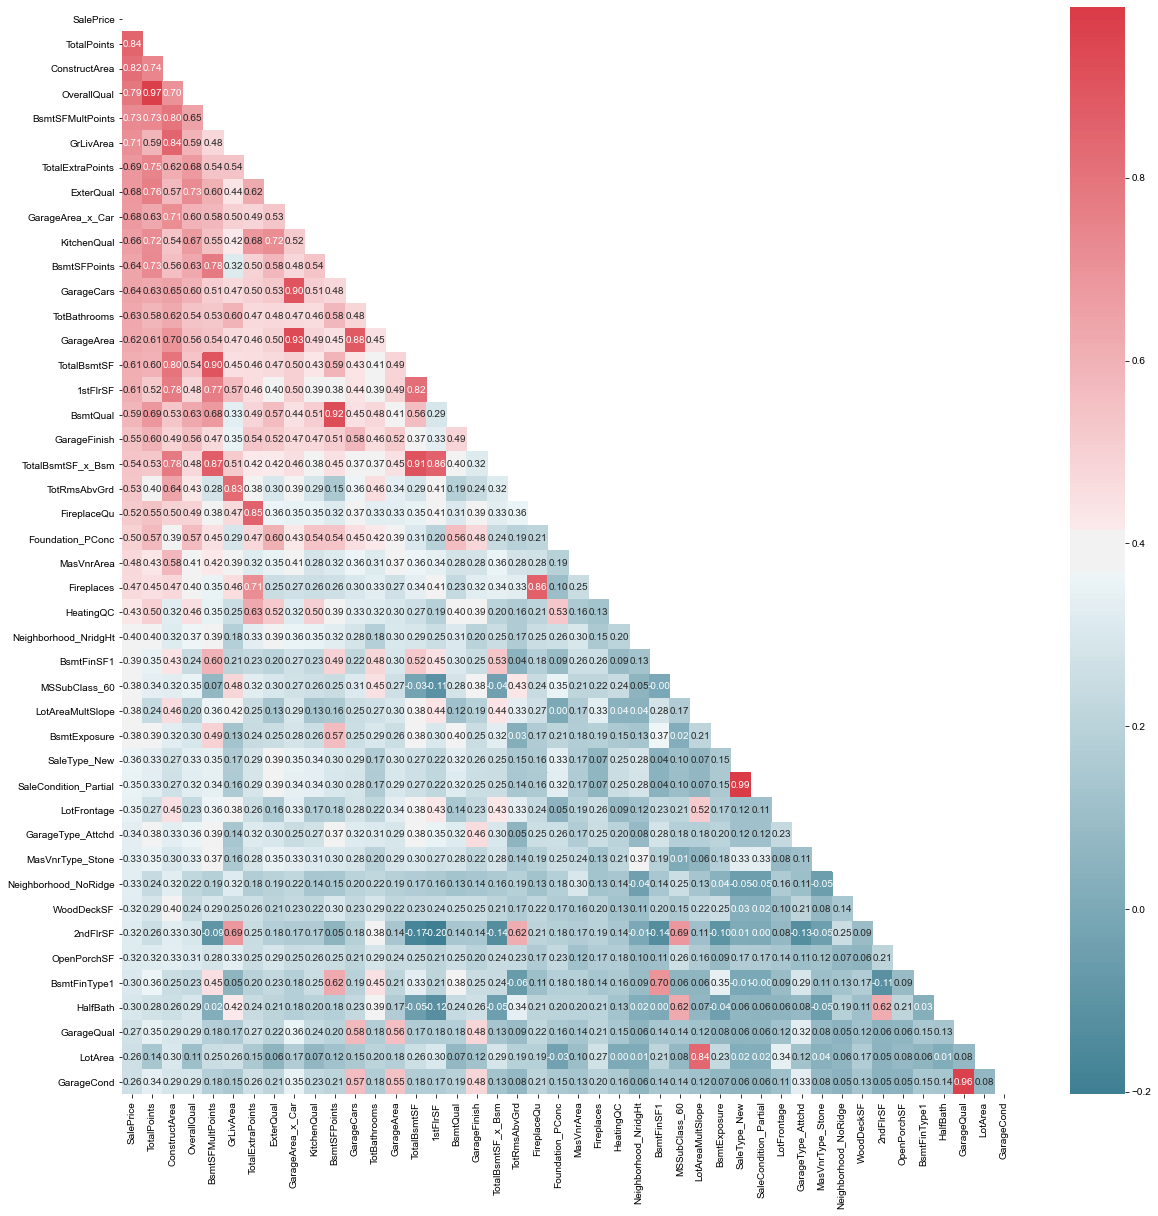

In [26]:
import seaborn as sns

corr = all_data[all_data.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.26)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.5)
plt.show()
del corr, dropSelf, top_corr

In [27]:
### Drop the features with highest correlations to other Features
all_data.drop(['FireplaceQu', 'BsmtSFPoints', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'OverallQual', 'GrLivArea', 
               'TotalBsmtSF_x_Bsm', '1stFlrSF', 'PoolArea', 'LotArea', 'SaleCondition_Partial', "2ndFlrSF","BsmtFinType1", "3SsnPorch",
               'GarageCond', 'HouseStyle_2Story', 'BsmtSFMultPoints', 'LowQualFinSF', 'BsmtFinSF2',"MSSubClass_60"
               ], axis=1, inplace=True) 

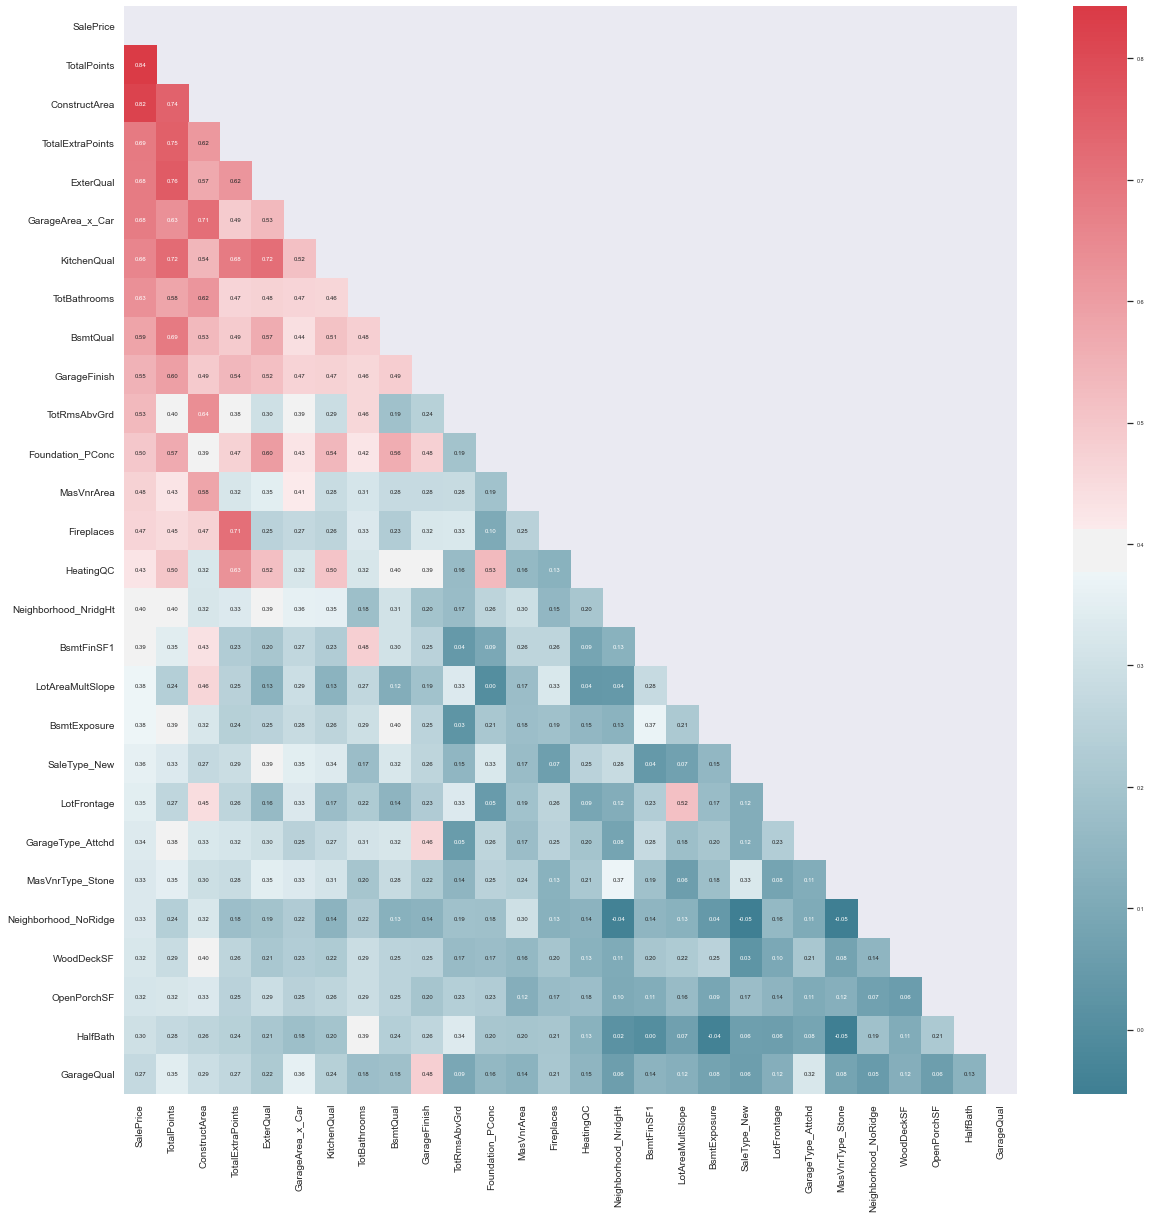

In [28]:
corr = all_data[all_data.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.26)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()
del corr, dropSelf, top_corr

In [29]:
all_data.rename(columns={'2ndFlrSF':'SndFlrSF'}, inplace=True)
def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['SalePrice'] = y.values
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

# Remove the higest correlations and run a multiple regression
cols = all_data.columns
cols = cols.drop(['SalePrice'])
vif = VRF('SalePrice', all_data.loc[all_data.SalePrice>0, cols], all_data.SalePrice[all_data.SalePrice>0])


E:\anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.000,Intercept
1,1.143,Id
36,1.199,ScreenPorch
39,1.209,YrSold
38,1.220,MiscVal
11,1.408,ExterCond
21,1.418,BsmtHalfBath
3,1.434,Street
35,1.451,EnclosedPorch
22,1.527,FullBath


In [30]:
# Remove one feature with VIF on Inf from the same category and run a multiple regression
cols = cols.drop(['Condition1_PosN', 'Neighborhood_NWAmes', 'BldgType_1Fam', 'RoofStyle_Flat',
               'LandContour_Bnk', 'LotConfig_Corner', 'GarageType_2Types', 'MSSubClass_45',
                  'MasVnrType_BrkCmn', 'Foundation_CBlock',  'SaleType_COD'])

vif = VRF('SalePrice', all_data.loc[all_data.SalePrice>0, cols], all_data.SalePrice[all_data.SalePrice>0])

E:\anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.000,Intercept
1,1.143,Id
130,1.154,Foundation_Wood
154,1.166,SaleType_Con
159,1.177,SaleType_Oth
68,1.185,Neighborhood_Blueste
65,1.192,LotConfig_FR3
36,1.199,ScreenPorch
39,1.209,YrSold
97,1.212,Condition1_RRNe


In [31]:
# Remove one feature with highest VIF from the same category and run a multiple regression
cols = cols.drop(['PoolQC', 'BldgType_TwnhsE', 'BsmtFinSF1', 'BsmtUnfSF', 
                  'GarageQual', 'GarageType_Attchd', 'HouseStyle_1Story', 'MasVnrType_None',
     'RoofStyle_Gable', 'SaleCondition_Normal', 'MoSold_10',
                  'SaleType_New', 'WoodDeckSF', 'BldgType_Duplex', 'MSSubClass_90'])
              
vif = VRF('SalePrice', all_data.loc[all_data.SalePrice>0, cols], all_data.SalePrice[all_data.SalePrice>0])

,VIF Factor,features
0,1.000,Intercept
150,1.098,SaleCondition_Family
141,1.125,SaleType_Con
145,1.128,SaleType_Oth
1,1.132,Id
143,1.143,SaleType_ConLI
119,1.145,Foundation_Wood
140,1.152,SaleType_CWD
32,1.167,ScreenPorch
62,1.175,Neighborhood_Blueste


In [32]:
all_data.to_csv("all_data_cleaned.csv")

In [33]:
train = all_data.loc[(all_data.SalePrice>0), cols].reset_index(drop=True, inplace=False)
test = all_data.loc[(all_data.SalePrice==0), cols].reset_index(drop=True, inplace=False)

In [34]:
train["SalePrice"]=all_data["SalePrice"]

In [35]:
train.to_csv("train_cleaned.csv")
test.to_csv("test_cleaned.csv")